In [1]:
!pip install cubist
!pip install kmodes
!pip install ucimlrepo
!pip install ipdb
!pip install scikeras
!pip install --upgrade kneed
!pip3 install tabulate
from ucimlrepo import fetch_ucirepo
from sklearn import datasets
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from cubist import Cubist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from keras.models import Sequential
from kmodes.kprototypes import KPrototypes
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
from scikeras.wrappers import KerasRegressor
from scipy import stats
from kneed import KneeLocator
from tabulate import tabulate
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import ipdb;ipdb
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf



## Data Preparation

In [2]:
# Import the datset
seoul_bike_sharing_demand = fetch_ucirepo(id=560)
X = seoul_bike_sharing_demand.data.features
y = seoul_bike_sharing_demand.data.targets
bike_df = pd.concat([X, y], axis=1)

# Display the first 5 rows of the dataset
print(bike_df.head(5))

        Date  Rented Bike Count  Hour  Temperature  Humidity  Wind speed  \
0  1/12/2017                254     0         -5.2        37         2.2   
1  1/12/2017                204     1         -5.5        38         0.8   
2  1/12/2017                173     2         -6.0        39         1.0   
3  1/12/2017                107     3         -6.2        40         0.9   
4  1/12/2017                 78     4         -6.0        36         2.3   

   Visibility  Dew point temperature  Solar Radiation  Rainfall  Snowfall  \
0        2000                  -17.6              0.0       0.0       0.0   
1        2000                  -17.6              0.0       0.0       0.0   
2        2000                  -17.7              0.0       0.0       0.0   
3        2000                  -17.6              0.0       0.0       0.0   
4        2000                  -18.6              0.0       0.0       0.0   

  Seasons     Holiday Functioning Day  
0  Winter  No Holiday             Yes  


In [3]:
# Check the data types of the variables
bike_df.dtypes

Date                      object
Rented Bike Count          int64
Hour                       int64
Temperature              float64
Humidity                   int64
Wind speed               float64
Visibility                 int64
Dew point temperature    float64
Solar Radiation          float64
Rainfall                 float64
Snowfall                 float64
Seasons                   object
Holiday                   object
Functioning Day           object
dtype: object

In [4]:
# Check if there are missing values in the datset
bike_df.isnull().sum()

Date                     0
Rented Bike Count        0
Hour                     0
Temperature              0
Humidity                 0
Wind speed               0
Visibility               0
Dew point temperature    0
Solar Radiation          0
Rainfall                 0
Snowfall                 0
Seasons                  0
Holiday                  0
Functioning Day          0
dtype: int64

In [6]:
# Check if there are duplicated data
bike_df.duplicated().sum()

0

## Exploratory data analysis (EDA)

In [67]:
#Show the basic statistics description
bike_df_description = bike_df.describe(include='all')
print(bike_df_description)

             Date  Rented Bike Count         Hour  Temperature     Humidity  \
count        8760        8760.000000  8760.000000  8760.000000  8760.000000   
unique        365                NaN          NaN          NaN          NaN   
top     1/12/2017                NaN          NaN          NaN          NaN   
freq           24                NaN          NaN          NaN          NaN   
mean          NaN         704.602055    11.500000    12.882922    58.226256   
std           NaN         644.997468     6.922582    11.944825    20.362413   
min           NaN           0.000000     0.000000   -17.800000     0.000000   
25%           NaN         191.000000     5.750000     3.500000    42.000000   
50%           NaN         504.500000    11.500000    13.700000    57.000000   
75%           NaN        1065.250000    17.250000    22.500000    74.000000   
max           NaN        3556.000000    23.000000    39.400000    98.000000   

         Wind speed   Visibility  Dew point tempera

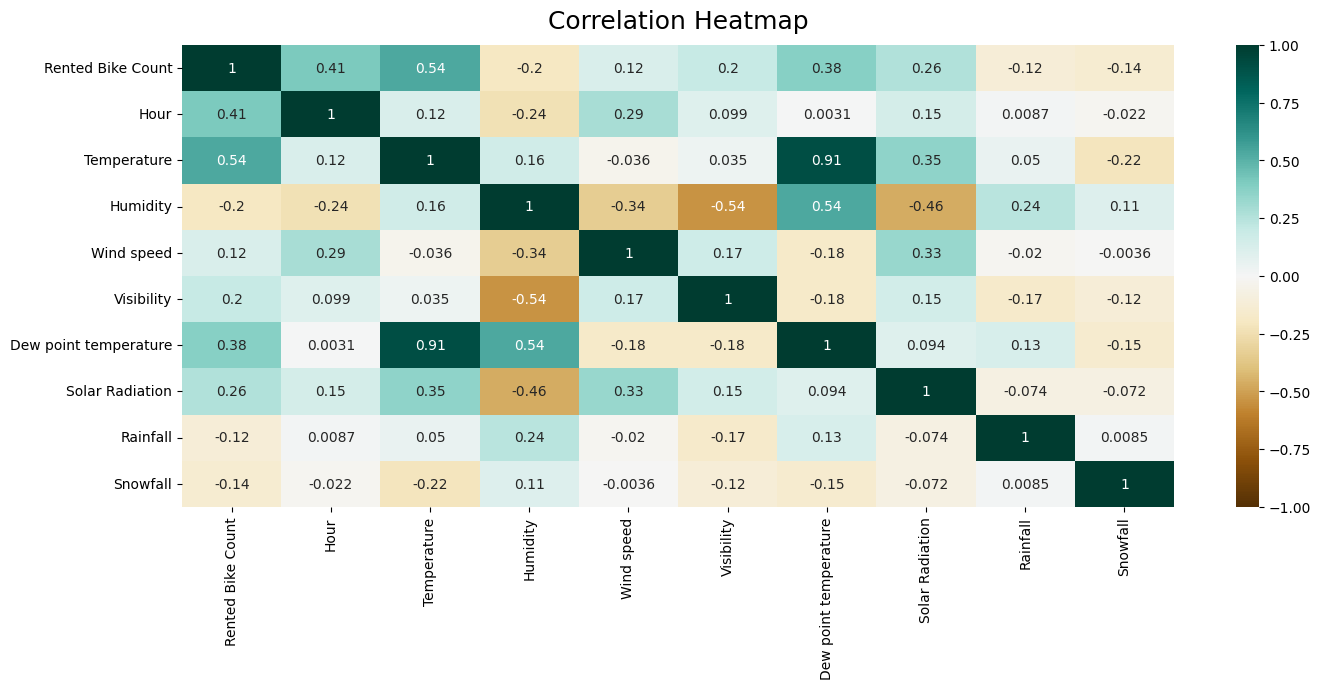

In [7]:
# Filter only numeric columns
numeric_bike_df = bike_df.select_dtypes(include=[np.number])

# Create a heatmap to show the correleations between numerical variables
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(numeric_bike_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

plt.show()

Based on the heatmap above, the rental bike demand positively correlates with temperature, hour, wind speed, visibility, dew point temperature, and solar radiation, among which temperature (0.54) shows the strongest positive correlation, followed by hour (0.41). It indicates the noticeable impact of temperature and hour on customer behaviors with regard to bicycle rentals, with a higher demand in warmer weather in general. On the other hand, it negatively correlates with humidity, snowfall and rainfall, with coefficients of -0.2 for humidity, -0.14 for snowfall, and -0.12 for rainfall

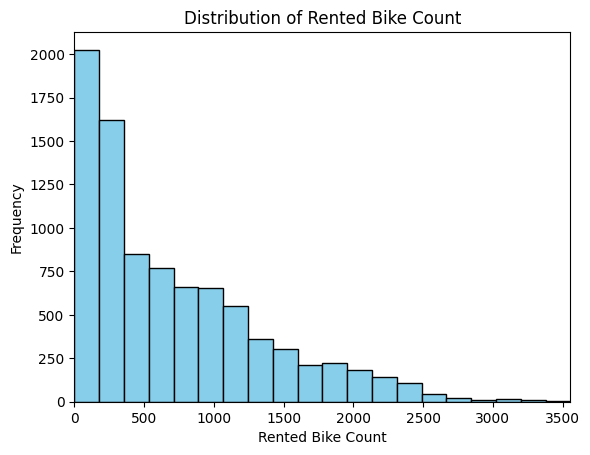

In [8]:
# Create a histogram for the 'Rented Bike Count' column
plt.hist(bike_df['Rented Bike Count'], bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Rented Bike Count')
plt.ylabel('Frequency')
plt.title('Distribution of Rented Bike Count')

# Adjust x-axis range
plt.xlim(0, bike_df['Rented Bike Count'].max())

# Show the plot
plt.show()

# The graph below shows that the rental bike demand follows a right-skewed distribution, , where lower numbers have higher frequencies

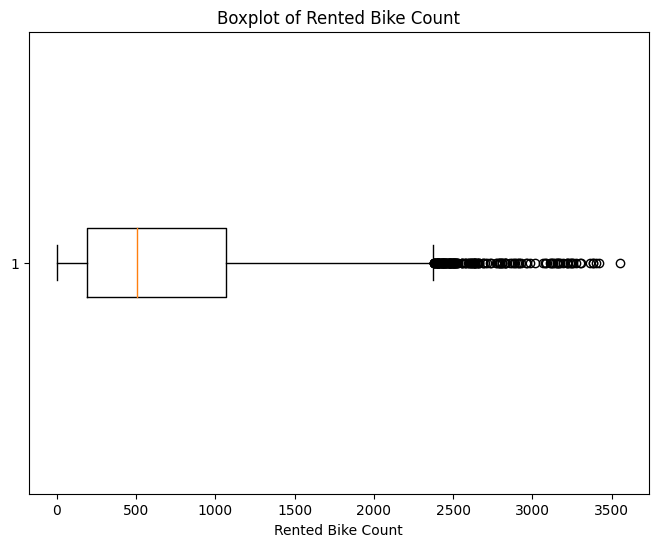

In [9]:
# Create a boxplot for the 'Rented Bike Count' to find out the outliers
plt.figure(figsize=(8, 6))
plt.boxplot(bike_df['Rented Bike Count'], vert=False)
# Add labels and title
plt.xlabel('Rented Bike Count')
plt.title('Boxplot of Rented Bike Count')
# Show the plot
plt.show()


In [11]:
# Calculate the upper bound/ outer upper fence of rented bike count

# Calculate the lower quartile
Q1 = np.percentile(bike_df['Rented Bike Count'], 25)
# Calculate the upper quartile
Q3 = np.percentile(bike_df['Rented Bike Count'], 75)

IQR = Q3 - Q1

# Calculate the upper bound
upper_bound = Q3 + 1.5 * IQR

print("Upper Bound for Outliers:", upper_bound)

Upper Bound for Outliers: 2376.625


The two graphs below indicate that the outliers (i.e., hours with more than 2376.62 rented bikes) mainly occur in the evening, with a few days experiencing busy mornings and outliers at 8 a.m., and the temperature is between 10°C and 30°C.

<ipython-input-12-fc0dfc28b306>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(bike_df['Temperature'], bike_df["Rented Bike Count"], c=colors, cmap='coolwarm')


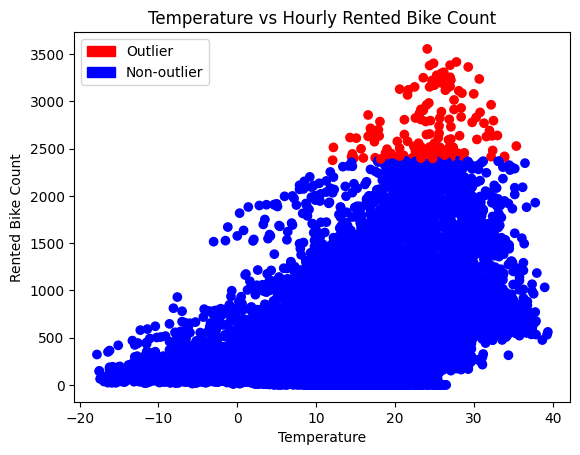

In [12]:
# The instances are outliers if rented bike counts are more than 2376.625
condition = bike_df["Rented Bike Count"] > 2376.625
# Red represents outliers and blue represents non-outliers
colors = np.where(condition, 'red', 'blue')

# Plot the scatter plot with different colors based on the condition
scatter = plt.scatter(bike_df['Temperature'], bike_df["Rented Bike Count"], c=colors, cmap='coolwarm')
plt.xlabel('Temperature')
plt.ylabel('Rented Bike Count')
plt.title('Temperature vs Hourly Rented Bike Count')
# Create a custom legend
red_patch = mpatches.Patch(color='red', label='Outlier')
blue_patch = mpatches.Patch(color='blue', label='Non-outlier')
plt.legend(handles=[red_patch, blue_patch])

plt.show()

<ipython-input-13-549237be2b39>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(bike_df['Hour'], bike_df["Rented Bike Count"], c=colors, cmap='coolwarm')


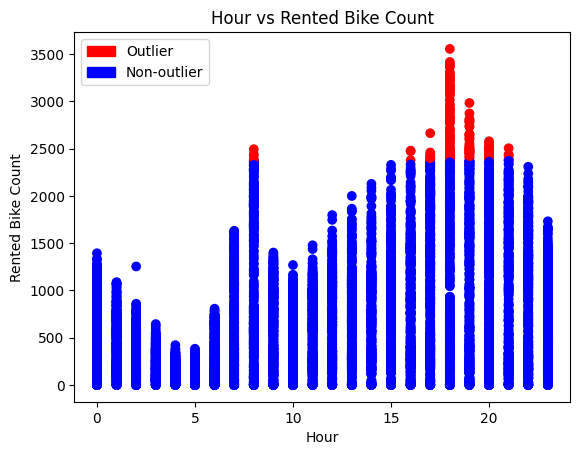

In [13]:
# The instances are outliers if rented bike counts are more than 2376.625
condition = bike_df["Rented Bike Count"] > 2376.625
# Red represents outliers and blue represents non-outliers
colors = np.where(condition, 'red', 'blue')

# Plot the scatter plot with different colors based on the condition
scatter = plt.scatter(bike_df['Hour'], bike_df["Rented Bike Count"], c=colors, cmap='coolwarm')
plt.xlabel('Hour')
plt.ylabel('Rented Bike Count')
plt.title('Hour vs Rented Bike Count')

# Create a custom legend
red_patch = mpatches.Patch(color='red', label='Outlier')
blue_patch = mpatches.Patch(color='blue', label='Non-outlier')
plt.legend(handles=[red_patch, blue_patch])

plt.show()

The graphs regarding the rental bike demand by seasons, months, and holidays/non-holidays are shown below.

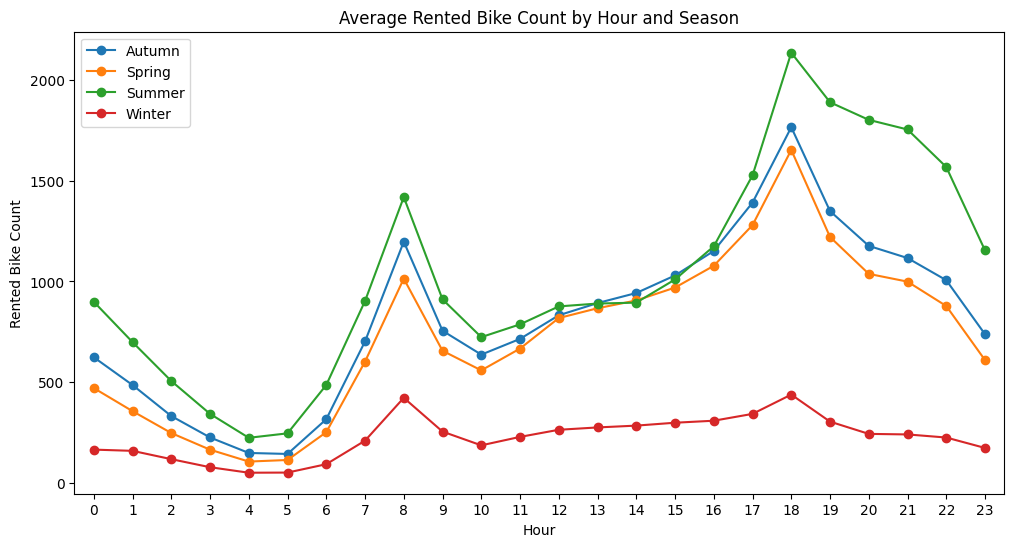

In [14]:
plt.figure(figsize=(12, 6))

# Group the data by 'Hour', 'Seasons', and calculate the mean 'Rented Bike Count' for each hour and season
hourly_season_counts = bike_df.groupby(['Hour', 'Seasons'])['Rented Bike Count'].mean().unstack()

# Plot a line plot for each season
for season in hourly_season_counts.columns:
    plt.plot(hourly_season_counts.index, hourly_season_counts[season], marker='o', label=season)

plt.xlabel('Hour')
plt.ylabel('Rented Bike Count')
plt.title('Average Rented Bike Count by Hour and Season')
plt.legend()
plt.xlim(-0.5, 23.5)
# make x-axis ticks to show all 24 hours
plt.xticks(range(24))

plt.show()

# Rental bike usage is significantly lower in winter compared to other seasons when the temperature is not too cold.
# Out of all four seasons, summer has the most usage for almost all hours of the day.

In [16]:
# Convert the column 'Date' in bike_df into a datetime format '%d/%m/%Y'
bike_df['Date'] = pd.to_datetime(bike_df['Date'], format='%d/%m/%Y')

# Separate Day, Month, and Year from 'Date'
bike_df['Day'] = bike_df['Date'].dt.day
bike_df['Month'] = bike_df['Date'].dt.month
bike_df['Year'] = bike_df['Date'].dt.year

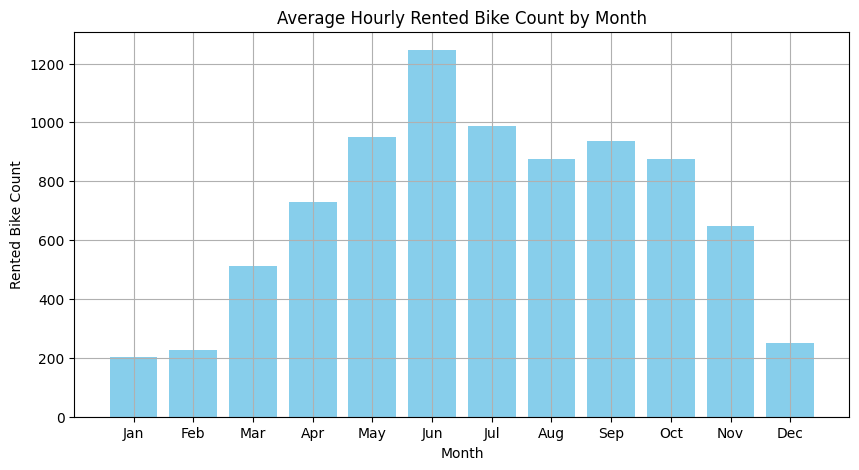

In [19]:
# Group by month and calculate mean rented bike count
bike_Monthly_count = bike_df.groupby('Month')['Rented Bike Count'].mean().reset_index()

# Create a bar chart
plt.figure(figsize=(10, 5))
plt.bar(bike_Monthly_count['Month'], bike_Monthly_count['Rented Bike Count'], color='skyblue')

plt.xlabel('Month')
plt.ylabel('Rented Bike Count')
plt.title('Average Hourly Rented Bike Count by Month')
plt.grid(True)
plt.xticks(bike_Monthly_count['Month'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.show()

# The rental bike demand is siginicantly higher in warmer months, with the peak being in June


<ipython-input-18-0ade5de96219>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=bike_df, x='Rented Bike Count', y='Holiday', inner='box', palette='Dark2',


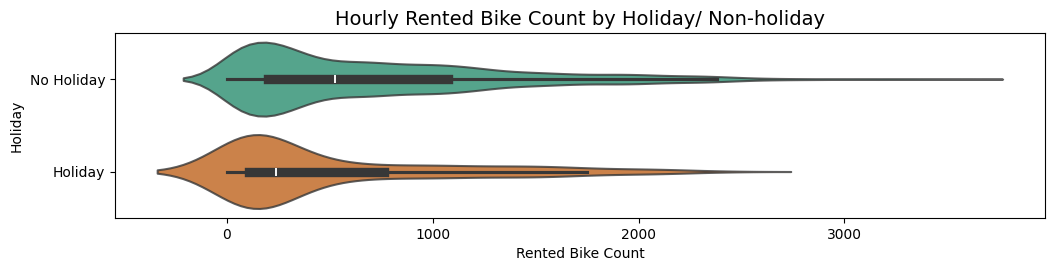

In [18]:
figsize_season_count = (12, 1.2 * len(bike_df['Holiday'].unique()))

# Create a figure and axis
fig, ax = plt.subplots(figsize=figsize_season_count)

# Plot violin plot with boxplot inside
sns.violinplot(data=bike_df, x='Rented Bike Count', y='Holiday', inner='box', palette='Dark2',
               linewidth=1.5, width=0.8, alpha=0.8, ax=ax)

# Set title
ax.set_title('Hourly Rented Bike Count by Holiday/ Non-holiday', fontsize=14)

# Show the plot
plt.show()

#  Based on the plot below, people in Seoul tend to rent more bikes on regular days compared to holidays

In [20]:
#Convert date back to string
bike_df['Date'] = bike_df['Date'].dt.strftime('%d/%m/%Y')
#Drop column 'Day', 'Month', and 'Year'
bike_df = bike_df.drop(columns=['Day', 'Month', 'Year'])

## Application of K-Prototypes Algorithm (Clustering)

In [21]:
# Make a copy of bike_df for clustering
Bike_df_cluster = bike_df.copy()

In [22]:
# Convert 'Date' column into datetime format
Bike_df_cluster['Date'] = pd.to_datetime(Bike_df_cluster['Date'], format='%d/%m/%Y')

# Separate Day, Month (abbreviation), and Year from 'Date'
Bike_df_cluster['Day'] = Bike_df_cluster['Date'].dt.day
Bike_df_cluster['Year'] = Bike_df_cluster['Date'].dt.year
Bike_df_cluster['Month'] = Bike_df_cluster['Date'].dt.strftime('%b')

# Extract Day of the Week (0 = Monday, 6 = Sunday) from date
Bike_df_cluster['Day of the week'] = Bike_df_cluster['Date'].dt.dayofweek
# Create new columns for week status (weekday/weekend) and day of the week (Monday to Sunday) categories
Bike_df_cluster['Week status'] = Bike_df_cluster['Day of the week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
Bike_df_cluster['Day of the week'] = Bike_df_cluster['Date'].dt.day_name()


In [23]:
#drop columns that are not needed for clustering
drop_col = ['Dew point temperature', 'Day', 'Year', 'Date']
Bike_df_cluster = Bike_df_cluster.drop(drop_col, axis=1)

In [24]:
# Get positions of categorical columns
catColumnsPos = [Bike_df_cluster.columns.get_loc(col) for col in Bike_df_cluster.select_dtypes('object').columns]

# Print the names and positions of the categorical columns
print('Categorical columns           : {}'.format(list(Bike_df_cluster.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['Seasons', 'Holiday', 'Functioning Day', 'Month', 'Day of the week', 'Week status']
Categorical columns position  : [9, 10, 11, 12, 13, 14]


In [25]:
# Convert dataframe to matrix
dfMatrix = Bike_df_cluster.to_numpy()

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


<function matplotlib.pyplot.show(close=None, block=None)>

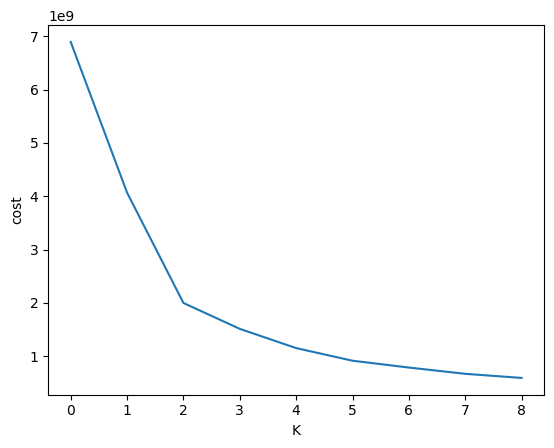

In [26]:
#Use elbow method to detect optimal number of K

cost = []
# Define the range of K
for cluster in range(1, 10):
    try:
        #Create a KPrototypes instance with the current number of clusters K
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
# Plotting the elbow curve
plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

In [32]:
from kneed import KneeLocator
# cost (sum distance): confirm visual clue of elbow plot
# KneeLocator class will detect elbows if curve is convex; if concave, will detect knees
knee_point = KneeLocator(
        x=range(1,10),
        y=cost,
        S=0.1, curve="convex", direction="decreasing", online=True)

print("Elbow at k =", f'{knee_point.elbow:.0f} clusters')

# the optimal number of clusters is 3


Elbow at k = 3 clusters


In [33]:
#Build the Kprototype model with 3 clusters
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 42)
Bike_df_cluster['clusters']= kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Analysis of K-Prototypes Clustering

<Axes: xlabel='clusters'>

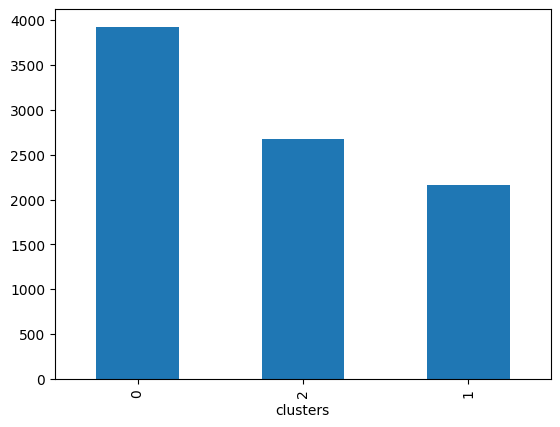

In [34]:
#Display the volume of each cluster
Bike_df_cluster['clusters'].value_counts().plot(kind='bar')

# The barplot shows the number occurrences in each cluster. Cluster 0 has the most observation (clost  to 4000)
#followed by cluster 2, with cluster 1 having the least occurrences

In [68]:
# Extract the nuemerical columns from the dataset
numeric_cols = Bike_df_cluster.select_dtypes(include=[np.number])

# Group numerical columns by clusters and compute mean statistics
mean_stats_by_cluster = numeric_cols.groupby(Bike_df_cluster['clusters']).mean()

# Display the mean by cluster of each column
print(mean_stats_by_cluster)

          Rented Bike Count       Hour  Temperature   Humidity  Wind speed  \
clusters                                                                     
0                393.555782   9.884615     8.799847  51.605196    1.781126   
1               1629.436893  16.110032    21.836015  51.625520    1.934350   
2                412.857357  10.141146    11.634182  73.303632    1.472669   

           Visibility  Solar Radiation  Rainfall  Snowfall  clusters  
clusters                                                              
0         1832.387927         0.532191  0.049924  0.063194       0.0  
1         1696.644013         0.891979  0.002820  0.000000       1.0  
2          645.001123         0.361917  0.411981  0.153313       2.0  


<ipython-input-36-8bc0c622890b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='clusters', y='Temperature', data=Bike_df_cluster, palette='viridis')
<ipython-input-36-8bc0c622890b>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='clusters', y='Hour', data=Bike_df_cluster, palette='viridis')


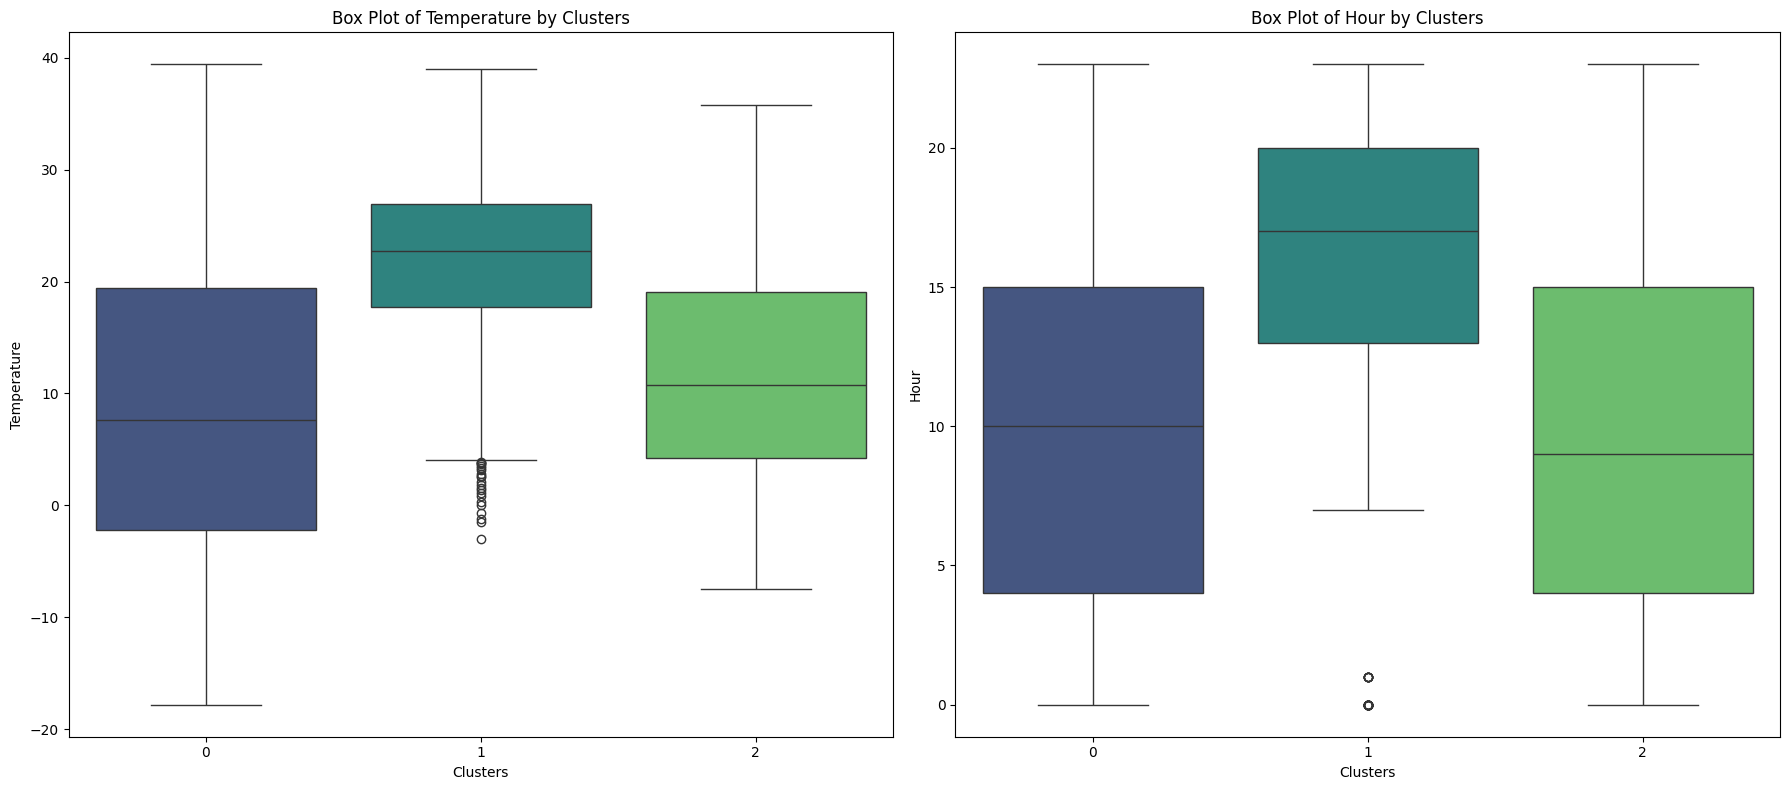

In [36]:
import seaborn as sns
# Create a figure with two subplots
plt.figure(figsize=(18, 8))

# Plotting the box plot of Temperature by Clusters
plt.subplot(1, 2, 1)
sns.boxplot(x='clusters', y='Temperature', data=Bike_df_cluster, palette='viridis')
plt.title('Box Plot of Temperature by Clusters')
plt.xlabel('Clusters')
plt.ylabel('Temperature')

# Plotting the second box plot of Hour by Clusters
plt.subplot(1, 2, 2)
sns.boxplot(x='clusters', y='Hour', data=Bike_df_cluster, palette='viridis')
plt.title('Box Plot of Hour by Clusters')
plt.xlabel('Clusters')
plt.ylabel('Hour')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

From the above two box plots, it can be observed that the temperatures of the occurrences in cluster 1 are significantly higher than those of the other two clusters. The occurrences in cluster 1 tend to happen later in the day (from late afternoon to night time), while the records of the other two clusters are mainly in the morning and early afternoon. All outliers are in cluster 1, with the median temperature being around 23°C and the median hour being 5pm. The main difference between clusters 0 and 2 is in the range of temperatures. The records with the highest and lowest temperatures are also found in cluster 0.

In [69]:
# Group by clusters and aggregate using lambda function to find mode
cluster_result_cat = Bike_df_cluster.groupby(['clusters']).agg(lambda x: pd.Series.mode(x).iat[0])[['Seasons', 'Holiday', 'Functioning Day', 'Month', 'Day of the week', 'Week status']]
print(cluster_result_cat)

         Seasons     Holiday Functioning Day Month Day of the week Week status
clusters                                                                      
0         Winter  No Holiday             Yes   Jan         Tuesday     Weekday
1         Summer  No Holiday             Yes   Jun       Wednesday     Weekday
2         Spring  No Holiday             Yes   Mar          Sunday     Weekday


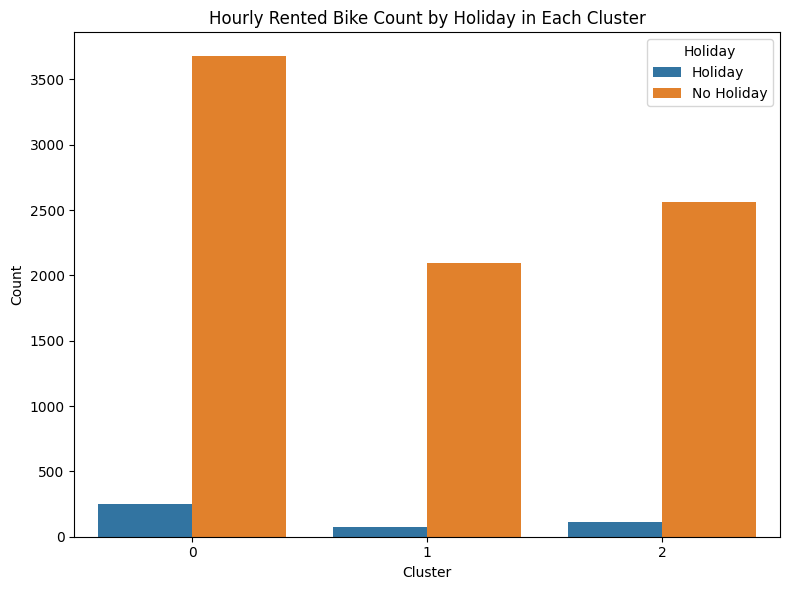

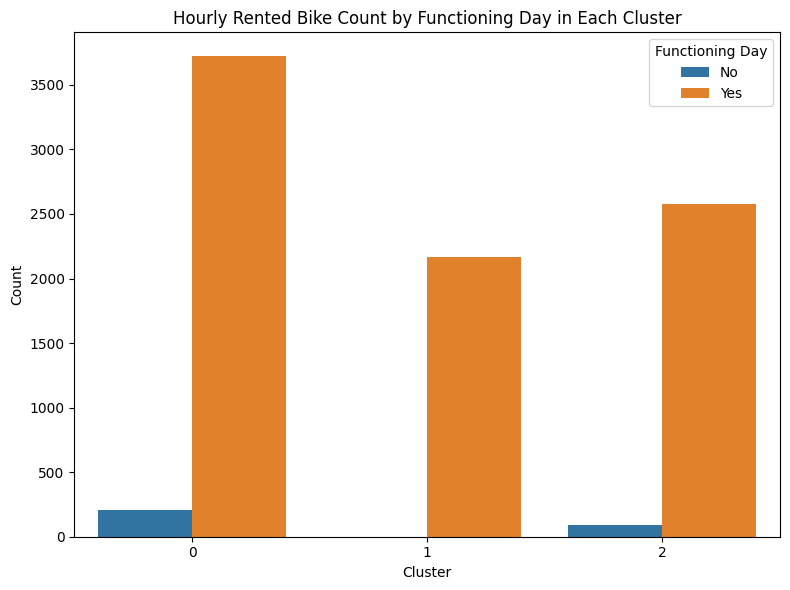

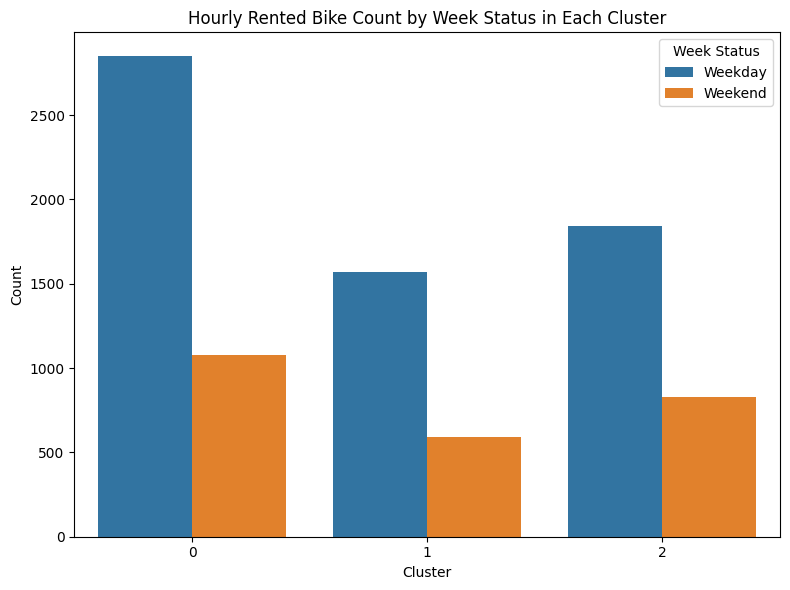

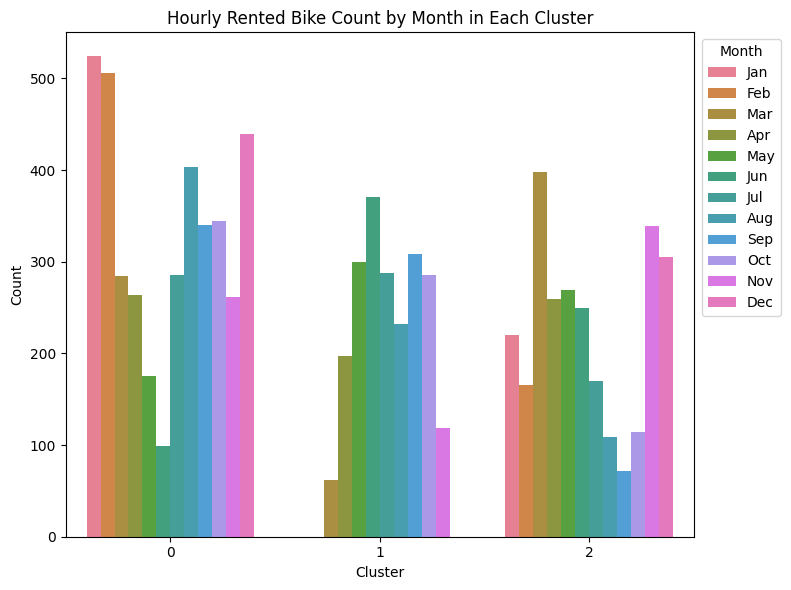

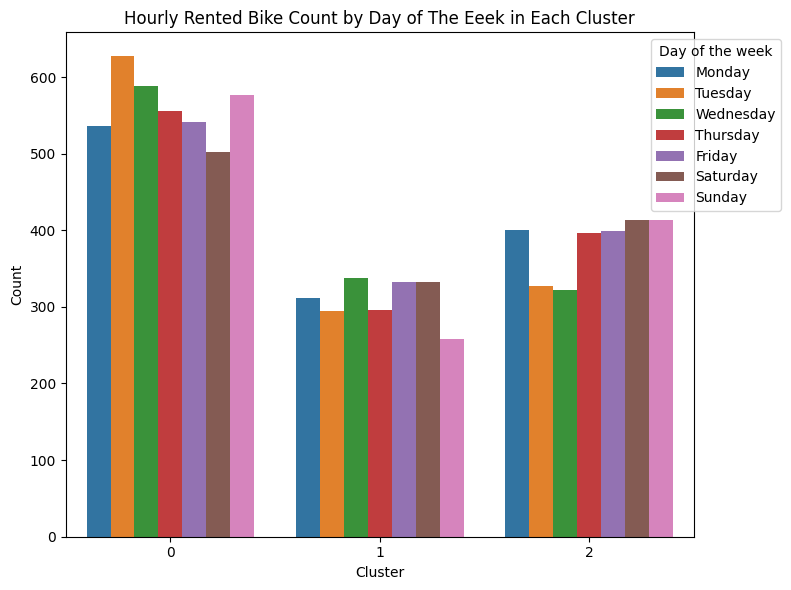

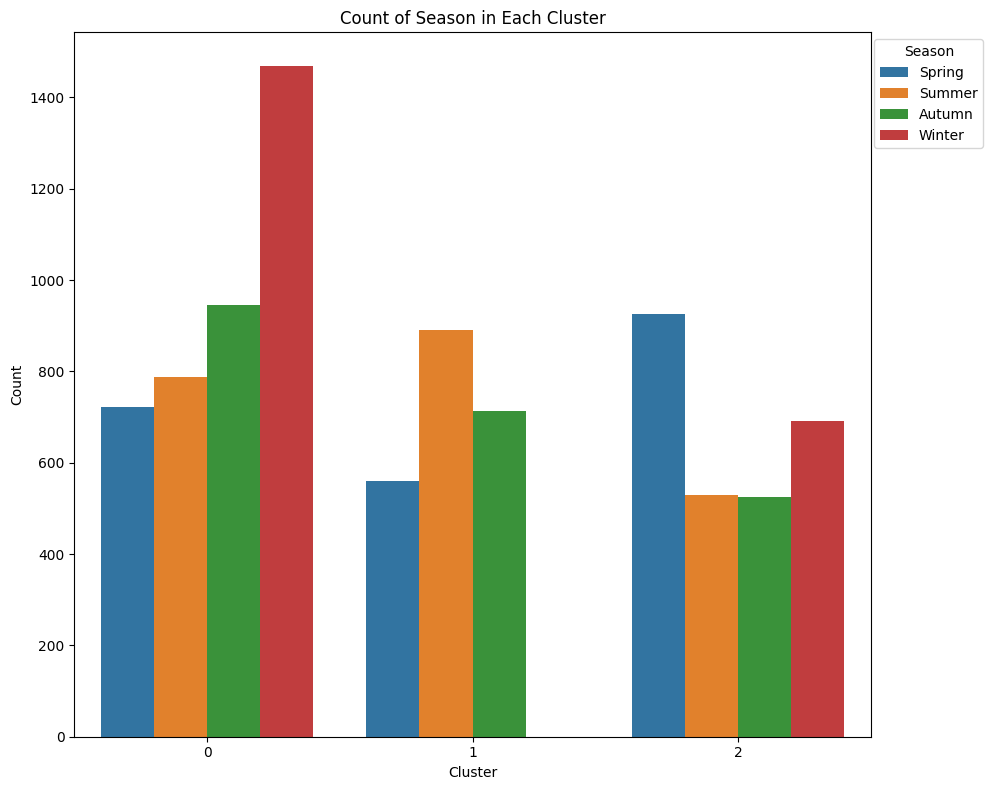

In [38]:
# Plotting Holiday by Clusters
holiday_counts = Bike_df_cluster.groupby(['clusters', 'Holiday']).size().reset_index(name='count')
plt.figure(figsize=(8, 6))
sns.barplot(x='clusters', y='count', hue='Holiday', data=holiday_counts)
plt.title('Hourly Rented Bike Count by Holiday in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Holiday')
plt.tight_layout()
plt.show()

# Plotting Functioning Day by Clusters
functioning_counts = Bike_df_cluster.groupby(['clusters', 'Functioning Day']).size().reset_index(name='count')
plt.figure(figsize=(8, 6))
sns.barplot(x='clusters', y='count', hue='Functioning Day', data=functioning_counts)
plt.title('Hourly Rented Bike Count by Functioning Day in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Functioning Day')
plt.tight_layout()
plt.show()


# Plotting Week_ tatus by Clusters
week_counts = Bike_df_cluster.groupby(['clusters', 'Week status']).size().reset_index(name='count')
plt.figure(figsize=(8, 6))
sns.barplot(x='clusters', y='count', hue='Week status', data=week_counts)
plt.title('Hourly Rented Bike Count by Week Status in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Week Status')
plt.tight_layout()
plt.show()

# Plotting Month by Clusters
Month_counts = Bike_df_cluster.groupby(['clusters', 'Month']).size().reset_index(name='count')
Month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(8, 6))
sns.barplot(x='clusters', y='count', hue='Month', data=Month_counts, hue_order=Month_order)
plt.title('Hourly Rented Bike Count by Month in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Month', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

# Plotting Day of the Week by Clusters
Day_of_the_week_counts = Bike_df_cluster.groupby(['clusters', 'Day of the week']).size().reset_index(name='count')
Day_of_the_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(8, 6))
sns.barplot(x='clusters', y='count', hue='Day of the week', data=Day_of_the_week_counts, hue_order=Day_of_the_week_order)
plt.title('Hourly Rented Bike Count by Day of The Eeek in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Day of the week', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

# Plotting Season by Clusters
season_counts = Bike_df_cluster.groupby(['clusters', 'Seasons']).size().reset_index(name='count')
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
plt.figure(figsize=(10, 8))  # Increase figure size for better visibility
sns.barplot(x='clusters', y='count', hue='Seasons', data=season_counts, hue_order=season_order)
plt.title('Count of Season in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Season', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

Based on the bar charts above, the main differences of thr 3 clusters are in months and seasons. While most of the records in cluster 1 are in Summer months (Jun-Aug), cluster 0 and 2 are in Winter months (Dec-Feb) and Spring months (March-May)

## Application of Four regression models

According to the past researches, there is no significant difference in rental bike demand between weekends and weekdays. To simplify the computation, feature engineering will not be conducted for the regression analysis. Additionally, the 'Dew point temperature' column will be dropped as there is a significant correlation between temperature and dew point temperature, and temperature has a higher correlation with the target variable (rented bike count).

In [3]:
# Make a copy of bike_df for regression models
Bike_df_regression = bike_df.copy

# Drop 'Dew point temperature' column from the dataset
Bike_df_regression = bike_df.drop('Dew point temperature', axis=1)
# Use one-hot encoding on categorical columns
Bike_df_encoded_data = pd.get_dummies(Bike_df_regression, columns = ['Date', 'Seasons', 'Holiday', 'Functioning Day'], dtype=float)

In [4]:
# Define a random seed for reproducibility
random_seed = 42

#Define the independent variables (X) and depentent (target) varibale (y)
X = Bike_df_encoded_data.loc[:, Bike_df_encoded_data.columns!='Rented Bike Count']
y = Bike_df_encoded_data['Rented Bike Count']
#Split the dataste into a 75% training set and a 25% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= random_seed)

## 1. Gradient Boosting Machine

Gradient Boosting Machine (before tuning) is used as a baseline model

In [41]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# Initialize the Gradient Boosting Regressor model
GBM_model = GradientBoostingRegressor(random_state=random_seed)

# Train the GBM on the training set
GBM_model.fit(X_train, y_train)

# Predict on the test set
GBM_y_pred = GBM_model.predict(X_test)

# Evaluate the model on test set uning R2, MSE, and MAE
GBM_r2 = r2_score(y_test, GBM_y_pred)
GBM_mse = mean_squared_error(y_test, GBM_y_pred)
GBM_mae = mean_absolute_error(y_test, GBM_y_pred)

# Display the result of the r2 socre
print(f"R-squared score of GBM (before tuning) on test set: {GBM_r2:.4f}")
print(f"Mean Squared Error (MSE) of GBM on test set: {GBM_mse:.4f}")
print(f"Mean Absolute Error (MAE) of GBM on test set: {GBM_mae:.4f}")


R-squared score of GBM (before tuning) on test set: 0.8198
Mean Squared Error (MSE) of GBM on test set: 73731.1542
Mean Absolute Error (MAE) of GBM on test set: 177.5795


A grid search of specified hyperparameters was conducted locally to determine the most optimal combination.. Due to the limitation of Google Colab (max. 12 hours run time) and the complexity of the computation, code below was run locally. the outcome of the codes below was {'max_depth': 9, 'n_estimators': 500}

In [ ]:
# Use grid search to find the best hyperparamters for GMB

# Initialize GBM
model = GradientBoostingRegressor(random_state=random_seed)

# Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': list(range(20, 520, 20)),  # n_estimators from 20 to 500
    'max_depth': list(range(1, 17, 2))       # max_depth from 1 to 15
}

# Define the Repeated K-Folds cross-validator with 10 splits and 3 repeats
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=random_seed)

# Initialize GridSearchCV on validation sets for hyperparameter tuning with R-squared as the scoring metric
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, verbose=2, scoring='r2')

# Execute the grid search on the training data
grid_result = grid_search.fit(X_train, y_train)

# Display the best hyperparameters found during grid search
print("Best hyperparameters of GBM:", grid_result.best_params_)

# Best hyperparameters of GBM: 'max_depth': 9, 'n_estimators': 500

In [7]:
# Initialize GBM with tuned hyperparameters
GBM_tuned = GradientBoostingRegressor(n_estimators=500, max_depth=9, random_state=random_seed)

# Train the tuned GBM on the training set
GBM_tuned.fit(X_train, y_train)

# Predict on the test set
GBM_tuned_pred = GBM_tuned.predict(X_test)

# Evaluate the model on test set uning R2, MSE, and MAE
GBM_tuned_r2 = r2_score(y_test, GBM_tuned_pred)
GBM_tuned_mse = mean_squared_error(y_test, GBM_tuned_pred)
GBM_tuned_mae = mean_absolute_error(y_test, GBM_tuned_pred)


# Display the result of the r2 socre
print(f"R-squared score of tuned GBM on test set: {GBM_tuned_r2:.4f}")
print(f"Mean Squared Error (MSE) of tuned GBM on test set: {GBM_tuned_mse:.4f}")
print(f"Mean Absolute Error (MAE) of tuned GBM on test set: {GBM_tuned_mae:.4f}")

R-squared score of tuned GBM on test set: 0.8998
Mean Squared Error (MSE) of tuned GBM on test set: 41001.2332
Mean Absolute Error (MAE) of tuned GBM on test set: 115.4504


## 2. CUBIST

In [45]:
# below are the performance of CIBUST (before tuning)

# Initialize the CUBIST model
CUBIST_model = Cubist(random_state=random_seed)

# Train the CUBIST on the training set
CUBIST_model.fit(X_train, y_train)

# Predict on the test set
CUBIST_y_pred = CUBIST_model.predict(X_test)

# Evaluate the model on test set uning R2, MSE, and MAE
CUBIST_r2 = r2_score(y_test, CUBIST_y_pred)
CUBIST_mse = mean_squared_error(y_test, CUBIST_y_pred)
CUBIST_mae = mean_absolute_error(y_test, CUBIST_y_pred)

# Display the result of the r2 socre
print(f"R-squared score of CUBIST (before tuning) on test set: {CUBIST_r2:.4f}")
print(f"Mean Squared Error (MSE) of CUBIST (before tuning) on test set: {CUBIST_mse:.4f}")
print(f"Mean Absolute Error (MAE) of CUBIST (before tuning) on test set: {CUBIST_mae:.4f}")


R-squared score of CUBIST (before tuning) on test set: 0.8406
Mean Squared Error (MSE) of CUBIST (before tuning) on test set: 65240.1888
Mean Absolute Error (MAE) of CUBIST (before tuning) on test set: 151.0555


Same for Cubist, due to the complexity of the computation, the code for grid search was run locally. it was found that the best combination of CIBUST is 'n_committees': 50, 'neighbors': 3

In [ ]:
# Use grid search on the training set to the best hyperparameters for CUBIST

# hyperparameter grid to search over
n_committees_list = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
neighbors_list = [1, 3, 5, 7]

# Define the Repeated K-Folds cross-validator with 10 splits and 3 repeats
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=random_seed)

# Initialize variables to store the best parameters and the best score
best_score = -np.inf
best_params = {}

# Grid search
for n_committees in n_committees_list:
    for neighbors in neighbors_list:
        model = Cubist(n_committees=n_committees, neighbors=neighbors)

        # Initialize a list to store cross-validated scores
        cv_scores = []

        # Perform cross-validation
        for train_ix, val_ix in cv.split(X_train):
            X_train_cv, X_val_cv = X_train.iloc[train_ix], X_train.iloc[val_ix]
            y_train_cv, y_val_cv = y_train.iloc[train_ix], y_train.iloc[val_ix]

            # Fit the model on the training data
            model.fit(X_train_cv, y_train_cv)

            # Predict on the validation data
            y_pred_cv = model.predict(X_val_cv)

            # Calculate the R2 score for this fold
            score = r2_score(y_val_cv, y_pred_cv)

            # Store the score
            cv_scores.append(score)

        # Calculate the mean cross-validated score
        mean_cv_score = np.mean(cv_scores)

        # Update the best score and parameters if the model in this fold is better
        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_params = {'n_committees': n_committees, 'neighbors': neighbors}

# Display the best hyperparameters found during grid search
print("Best hyperparameters of CUBIST:", best_params)

# Best hyperparameters of CUBIST: 'n_committees': 50, 'neighbors': 3

In [8]:
# Initialize CUBIST with tuned hyperparameters
CUBIST_tuned = Cubist(n_committees=50, neighbors=3, random_state=random_seed)

# Train the tuned CUBIST on the training set
CUBIST_tuned.fit(X_train, y_train)

# Predict on the test set
CUBIST_tuned_y_pred = CUBIST_tuned.predict(X_test)

# Evaluate the model on test set uning R2, MSE, and MAE
CUBIST_tuned_r2 = r2_score(y_test, CUBIST_tuned_y_pred)
CUBIST_tuned_mse = mean_squared_error(y_test, CUBIST_tuned_y_pred)
CUBIST_tuned_mae = mean_absolute_error(y_test, CUBIST_tuned_y_pred)

# Display the result of the r2 socre
print(f"R-squared score of tuned CUBIST on test set: {CUBIST_tuned_r2:.4f}")
print(f"Mean Squared Error (MSE) of tuned CUBIST on test set: {CUBIST_tuned_mse:.4f}")
print(f"Mean Absolute Error (MAE) of tuned CUBIST on test set: {CUBIST_tuned_mae:.4f}")



R-squared score of tuned CUBIST on test set: 0.9201
Mean Squared Error (MSE) of tuned CUBIST on test set: 32680.6712
Mean Absolute Error (MAE) of tuned CUBIST on test set: 104.1602


## 3. Multi Layer Perceptron (MLP)

Similar to the previous models, due to the complexity of the computation, the code for grid search was run locally. The best hyperprameters are 2, 250, and 0.001 for batch size, number of epoch, and learning rate, respectively.
The model has 4 layers with differenct sizes. The input data is standardized to make sure the values have a zero mean with a unit standard deviation. This preprocessing method significantly improved the results.

In [ ]:
# Convert dataframe to numpy
X_train_np, X_test_np, y_train_np, y_test_np = X_train.values, X_test.values, y_train.values, y_test.values

# Separate numerical and categorical features
numerical_indices = list(range(9))
categorical_indices = list(range(9, X_train_np.shape[1]))
X_train_numerical = X_train_np[:, numerical_indices]
X_train_categorical = X_train_np[:, categorical_indices]

# Standardize the data
scaler = StandardScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train_numerical)
X_test_numerical_scaled = scaler.transform(X_test_np[:, numerical_indices])
X_train_s = np.hstack((X_train_numerical_scaled, X_train_categorical))
X_test_s = np.hstack((X_test_numerical_scaled, X_test_np[:, categorical_indices]))

# Model defenition
def create_mlp_model():
    model = Sequential([
        Dense(200, input_dim=X_train_s.shape[1], activation='relu'),
        Dense(100, activation='relu'),
        Dense(50, activation='relu'),
        Dense(1, activation='relu')
    ])

    return model

# scikit-learn API wrapper for Keras.
MLP_model = KerasRegressor(build_fn=create_mlp_model, verbose=0, loss="mse", optimizer="Adam")

# Cross validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

# Grid search
param_grid = {
    'batch_size': list(range(2, 128, 10)),
    'epochs': list(range(50, 300, 50)),
    'optimizer__learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
}
grid = GridSearchCV(estimator= MLP_model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='r2', verbose=4)
grid_result = grid.fit(X_train_s, y_train)

# Display the best hyperparameters found during grid search
print("Best hyperparameters of MLP:", best_params)

# Best hyperparameters of CUBIST: 'batch size': 2, 'epochs': 250, 'learning rate': 0.001

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

# MLP with tuned huperparameters
MLP_model = create_mlp_model()
optimizer = Adam(learning_rate = 0.001)
MLP_model.compile(optimizer=optimizer, loss='mse')

# Train the tuned MLP on the training set
MLP_model.fit(X_train_s, y_train, epochs=250, validation_split=0., batch_size=2, verbose=0)

# Predict on the test set
MLP_tuned_y_pred = MLP_model.predict(X_test_s)

# Evaluate the model on test set (R-squared score, MSE)
MLP_tuned_r2 = r2_score(y_test, MLP_tuned_y_pred)
MLP_tuned_mse = mean_squared_error(y_test, MLP_tuned_y_pred)
MLP_tuned_mae = mean_absolute_error(y_test, MLP_tuned_y_pred)

# Display the result of the r2 socre
print("R-squared of tuned MLP on Test Set:", f"{MLP_tuned_r2:.4f}")
print(f"Mean Squared Error (MSE) of tuned MLP on test set: {MLP_tuned_mse:.4f}")
print(f"Mean Absolute Error (MAE) of tuned MLP on test set: {MLP_tuned_mae:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R-squared of tuned MLP on Test Set: 0.9453
Mean Squared Error (MSE) of tuned MLP on test set: 22390.3072
Mean Absolute Error (MAE) of tuned MLP on test set: 87.3906


## 4. Ridge Regression Model

Many different methods were tested to improve the ridge regression model, like scaling, dropping more features, and grid search. It was found that the optimal approach involved not scaling numerical features, dropping only the 'Dew point temperature' feature, and using the default alpha value of 1.

In [48]:
# Use grid search on the training set to the best hyperparameters for ridge regression model

# Initialize the Ridge Regression model
model = Ridge(random_state=random_seed)

# Define the parameter grid to search over
grid = dict()
grid['alpha'] = np.logspace(0, 40, 160)  # Logarithmically spaced alpha values for Ridge

# Define the Repeated K-Folds cross-validator with 10 splits and 3 repeats
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=random_seed)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, verbose=2, scoring='r2')

# Execute the grid search on the training data
grid_result = grid_search.fit(X_train, y_train)

# Summarize the best score and configuration
print("Best hyperparameters of ridge regression:", grid_result.best_params_)

Fitting 30 folds for each of 160 candidates, totalling 4800 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best hyperparameters of ridge regression: {'alpha': 1.0}


In [9]:
# Initialize Ridge Regression model
ridge_reg = Ridge(alpha=1, random_state=random_seed)

# Train the model on the training set
ridge_reg.fit(X_train, y_train)

# Predict on the test set
ridge_reg_y_pred = ridge_reg.predict(X_test)

# Evaluate the model on test set uning R2 score
ridge_reg_r2 = r2_score(y_test, ridge_reg_y_pred)
ridge_reg_mse = mean_squared_error(y_test, ridge_reg_y_pred)
ridge_reg_mae = mean_absolute_error(y_test, ridge_reg_y_pred)

# Display the result of the r2 socre
print("R-squared of ridge regression model on Test Set:", ridge_reg_r2)
print(f"Mean Squared Error (MSE) of ridge regression model on test set: {ridge_reg_mse:.4f}")
print(f"Mean Absolute Error (MAE) of ridge regression model on test set: {ridge_reg_mae:.4f}")


R-squared of ridge regression model on Test Set: 0.6257589446404239
Mean Squared Error (MSE) of ridge regression model on test set: 153139.8078
Mean Absolute Error (MAE) of ridge regression model on test set: 296.6484


## Summary of the Performance of the Four Regression Models

In [12]:
table_data = [
    ["GBM (Tuned)", GBM_tuned_r2, GBM_tuned_mse, GBM_tuned_mae],
    ["CUBIST (Tuned)", CUBIST_tuned_r2, CUBIST_tuned_mse, CUBIST_tuned_mae],
    ["MLP (Tuned)", MLP_tuned_r2, MLP_tuned_mse, MLP_tuned_mae],
    ["Ridge Regression", ridge_reg_r2, ridge_reg_mse, ridge_reg_mae],
]

print(tabulate(table_data, headers=['Model', 'R-squared Score', 'MSE', 'MAE'], tablefmt='fancy_grid'))

# Out of the 4 models, MLP has the strongest performance, with the highest r2, and the lowest mse and mae


╒══════════════════╤═══════════════════╤══════════╤══════════╕
│ Model            │   R-squared Score │      MSE │      MAE │
╞══════════════════╪═══════════════════╪══════════╪══════════╡
│ GBM (Tuned)      │          0.899802 │  41001.2 │ 115.45   │
├──────────────────┼───────────────────┼──────────┼──────────┤
│ CUBIST (Tuned)   │          0.920135 │  32680.7 │ 104.16   │
├──────────────────┼───────────────────┼──────────┼──────────┤
│ MLP (Tuned)      │          0.945283 │  22390.3 │  87.3906 │
├──────────────────┼───────────────────┼──────────┼──────────┤
│ Ridge Regression │          0.625759 │ 153140   │ 296.648  │
╘══════════════════╧═══════════════════╧══════════╧══════════╛
